In [1]:
import os
import re
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
filename = 'hsd-comal-kfold'
epochs = 10
batch_size = 64
sequence_length = 80
min_increment = 200

# LOAD AND PREPROCESS DATA

In [5]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [6]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [7]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [8]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)
label_columns = data.columns[1:]  

# BULDING DATASET

In [13]:
class ClfDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(label2id)  # Total number of labels
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx] 
        labels = self.gt_labels[idx]

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            item,
            padding='max_length',
            truncation=True,
            max_length=self.maxlength,
            return_tensors="pt"
        )

        # Extract tokenized fields
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)

        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample selection

        # Return inputs for model: tokenized text, labels, sample index, sampling weights, labeling status
        inputs_list = [text_inputs, labels, idx, sampler_loss_weight, self.all_labeled_mask[idx]]
        return inputs_list

In [14]:
def load_data(X_train, y_train, X_val, y_val, label2id):
    tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
    
    train_dataset = ClfDataset(
        data=X_train,
        labels=y_train,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    val_dataset = ClfDataset(
        data=X_val,
        labels=y_val,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    
    return train_dataset, val_dataset, len(X_train), len(X_val)

def load_label():
    label_freq_desc = [['HS', 1], ['Abusive', 1], ['HS_Individual', 1], ['HS_Group', 1], ['HS_Religion',1], ['HS_Race', 1], ['HS_Physical', 1], ['HS_Gender', 1], ['HS_Other', 1], ['HS_Weak', 1], ['HS_Moderate', 1], ['HS_Strong', 1]]
    label_weight = [x[1] for x in label_freq_desc]
    label_index = [x[0] for x in label_freq_desc]
    labels = label_index
    label2id = {j: i for i, j in enumerate(labels)}
    print('label num', len(labels))
    return len(labels), label2id

def label2list(label):
    print(label)
    outputs = [[] for _ in range(label.shape[0])]
    x,y = np.where(label==1)
    for xx,yy in zip(x,y):
        outputs[xx].append(yy)
    return outputs

# DEFINE THE MODEL

In [15]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [16]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = 12
        self.cl_neg_mode = 1
        self.proto_size = 256
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, 12 * 256)
        self.fc1 = nn.Linear(256, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 256)
        self.agg = nn.Linear(self.label_num * 256, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None):
        # Ensure prototypes and other buffers are on the same device as the input
        device = x.device
        self.prototypes = self.prototypes.to(device)
        self.ins_pos_cnt = self.ins_pos_cnt.to(device)
        if self.cl_neg_mode in [1, 2]:
            self.ins_neg_cnt = self.ins_neg_cnt.to(device)
            
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask)
            
            # Update positive instance counts and normalize prototypes
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes
        elif self.cl_neg_mode == 0 or self.cl_neg_mode == 1:
            dist_1 = sub_rep_norm @ self.prototypes.T  # Standard matrix multiplication for distance calculation

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [17]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=1):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=1):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [18]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

def train_total_sep2(dataloaders, trials, metrics, current_train_size, label_num=-1, seed=42, total_patience=3):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_score = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }
    best_score2 = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }
    second_phase = False
    total_patience_cnt = 0
    models = {}

    # Initialize models and move to multiple GPUs
    models['backbone'] = IndoBERT_Backbone(label_num).to(device)
    models['vae_module'] = MLP_VAE(768, device).to(device)

    # Optimizers
    optim_backbone = optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)
    optim_module = optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

    # Mixed precision scaler
    scaler = GradScaler()

    # Loaders
    train_loader = dataloaders['labeled']
    val_loader = dataloaders['test']

    print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        models['vae_module'].reset_proto()

        # Set training or evaluation modes
        if second_phase:
            models['backbone'].eval()
        else:
            models['backbone'].train()
        models['vae_module'].train()

        total_loss = 0

        for data in train_loader:
            optim_backbone.zero_grad()
            optim_module.zero_grad()

            labels, idx, loss_weight, _ = [x.to(device) for x in data[1:]]
            input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]

            loss = 0

            with autocast():
                clf_out, encoder_cls = models['backbone'](inputs_list)
    
                # VAE forward pass
                module_cls = encoder_cls.detach()
                recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight)
    
                # Contrastive loss
                cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
                cl_labels_total = cl_labels.unsqueeze(-1)
                proj_total = latent_rep.view(-1, latent_rep.shape[-1])
                proj_total = F.normalize(proj_total, dim=-1)
                batch_size = clf_out.shape[0] * label_num
                mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)
    
                criterion_cl = SupConLoss()
                cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
    
                # Reconstruction and classification loss
                criterion_mse = nn.MSELoss()
                recon_mse_loss = criterion_mse(recon_x, module_cls)
                criterion_bce = nn.BCEWithLogitsLoss()
                recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
    
                loss2 = cl_loss + recon_mse_loss + recon_bce_loss
    
                if not second_phase:
                    clf_loss = criterion_bce(clf_out, labels.float())
                    loss += clf_loss
    
                loss += loss2
    
            scaler.scale(loss).backward()
            total_loss += loss.item()

            if second_phase:
                scaler.step(optim_module)
            else:
                scaler.step(optim_module)
                scaler.step(optim_backbone)
            scaler.update()

        score = test(device, models, epoch, dataloaders)

        if score["f1_micro"] >= best_score['f1_micro']:
            best_score = score

            torch.save(models['backbone'].state_dict(), f"{filename}-p1-backbone-fold-{trials + 1}.pth")
            torch.save(models['vae_module'].state_dict(), f"{filename}-p1-vae-fold-{trials + 1}.pth")

        print(f"EPOCH {epoch} | LOSS: {total_loss / len(train_loader)} | ACCURACY: {score['accuracy'].round(4)} | F1 MICRO: {score['f1_micro'].round(4)} | F1 MACRO: {score['f1_macro'].round(4)}")

    duration = time.time() - start_time
    print(f"Training completed in {duration} s")

    metrics[0].append(current_train_size)
    metrics[1].append(best_score['accuracy'])
    metrics[2].append(best_score['f1_micro'])
    metrics[3].append(best_score['f1_macro'])

    print(f"Iteration {current_train_size}: ACCURACY {best_score['accuracy'].round(4)} | F1 MICRO {best_score['f1_micro'].round(4)} | F1 MACRO {best_score['f1_macro'].round(4)}")
    print(best_score['report'])

In [20]:
def test(device, models, epoch, dataloaders, test_dual=False, final_test=False):
    outputs_clf = [[], [], [], [], []]
    outputs_dis = [[], [], [], [], []]
    outputs_dual = [[], [], [], [], []]
    outputs_z = [[], [], [], [], []]
    
    for key in models.keys():
        models[key].eval()
        
    with torch.no_grad():
        for data in dataloaders['test']:
            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
            labels = data[1].to(device)
            out = [input_ids, input_type_ids, input_mask, None]

            clf_out, encoder_cls = models['backbone'](out)
            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels)
            
            _, _, recon_x_clf, _ = models['vae_module'](encoder_cls)
            outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels)
            
    outputs_clf = concat_test_result(outputs_clf)

    result = {}
                                 
    if 'vae_module' in models.keys() and not final_test and test_dual:
        outputs_dual = concat_test_result(outputs_dual)
        true_labels_vae = outputs_dual[0]
        predicted_vae = []

        result['accuracy'] = hamming_accuracy(outputs_dual[0], outputs_dual[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_dual[0], outputs_dual[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_dual[0], outputs_dual[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_dual[0], 
            outputs_dual[4], 
            target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
            zero_division=0
        )
    else:
        result['accuracy'] = hamming_accuracy(outputs_clf[0], outputs_clf[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_clf[0], outputs_clf[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_clf[0], outputs_clf[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_clf[0], 
            outputs_clf[4], 
            target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
            zero_division=0
        )

    return result

def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 4)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = logits.data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

def hamming_accuracy(true_labels, pred_labels):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    correct = (true_labels == pred_labels).sum(axis=1)  # Count correct labels for each instance
    total_labels = true_labels.shape[1]  # Number of labels per instance
    return np.mean(correct / total_labels)  # Average over all instances

# QUERY STRATEGY

In [21]:
def query_samples(filename, dataset, current_train_size, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  X_train_fold, X_val_fold, y_train_fold, y_val_fold, label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=1, n_samples=min_increment):
    device = torch.device('cuda')

    models = {}
    backbone = IndoBERT_Backbone(num_labels)
    vae = MLP_VAE(768, device)

    current_train_size = len(dataset.get_labeled_set())

    backbone.load_state_dict(torch.load(f"{filename}-p1-backbone-fold-{trials+1}.pth"))
    models['backbone'] = backbone
    if os.path.exists(f'/kaggle/working/{filename}-p2-vae-fold-{trials+1}.pth'):
        vae.load_state_dict(torch.load(f"{filename}-p2-vae-fold-{trials+1}.pth"))
    else:
        vae.load_state_dict(torch.load(f"{filename}-p1-vae-fold-{trials+1}.pth"))
    models['vae_module'] = vae

    # Wrap models with DataParallel for multi-GPU support
    for key in models.keys():
        models[key] = models[key].to(device)
        models[key].eval()

    start_time = time.time()

    # Initialize lists to store outputs used for sampling calculations
    predictions, sample_indices = [], []
    sample_weights = []
    backbone_predictions = []
    backbone_distances = []
    ground_truth_labels = []
    vae_predictions = []
    sub_representations = []

    # If training with the VAE module, initialize labeled data processing
    labeled_sub_representations = []
    labeled_distances = []
    labeled_ground_truths = []

    # Labeled DataLoader
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    # Process labeled data to extract features and distances for sampling criteria
    for text_inputs, gt_label, idx, _, _ in labeled_dataloader:
        input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            _, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])

            # If VAE module is present, obtain sub-representations and distances
            if 'vae_module' in models.keys():
                _, sub_representation, _, vae_distance = models['vae_module'](encoded_cls)
                sub_representation = sub_representation.cpu().data  # N, L, d
                vae_distance = vae_distance.cpu().data
                labeled_distances.extend(vae_distance)
                labeled_sub_representations.extend(F.normalize(sub_representation, dim=-1))  # Normalized for comparison

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)  # N, L
    labeled_sub_representations = torch.stack(labeled_sub_representations)  # N, L, d
    labeled_distances = torch.stack(labeled_distances)  # N, L+1

    # Compute self-prototype distances based on CoMAL's contrastive learning mode
    if cl_neg_mode == 1:
        labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
        labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
        labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
        positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
    elif cl_neg_mode == 2:
        # Split distances into positive and negative based on contrastive learning mode
        positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
        positive_distances = positive_distances * labeled_ground_truths

    # Calculate max, min, and mean positive distances for uncertainty measurement
    max_positive_distances = torch.max(positive_distances, dim=0)[0]
    min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
    mean_positive_distances = (max_positive_distances + min_positive_distances) / 2

    # DataLoader for unlabeled data to compute sampling scores
    unlabeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
    )
    
    # Process unlabeled data to get sampling scores
    for text_inputs, labels, idx, loss_weight, _ in unlabeled_dataloader:
        input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]

        with torch.no_grad():
            # Get predictions and encoded representations
            predictions, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])
            predictions = predictions.cpu().data
            backbone_predictions.extend(predictions)

            # If VAE module exists, get latent representations, reconstructions, and distances
            if 'vae_module' in models.keys():
                recon_x, latent_rep, recon_x_clf, vae_distance = models['vae_module'](encoded_cls)
                latent_rep = latent_rep.cpu().data
                vae_distance = vae_distance.cpu().data
                recon_x_clf = recon_x_clf.cpu().data
                vae_predictions.extend(recon_x_clf)
                backbone_distances.extend(vae_distance)
                sub_representations.extend(F.normalize(latent_rep, dim=-1))  # Normalized latent space representation
            else:
                vae_predictions.extend(predictions)

        # Append sample indices, loss weights, and ground truth labels for use in ranking
        sample_indices.extend(idx)
        sample_weights.extend(loss_weight)
        ground_truth_labels.extend(labels)

     # Convert lists to tensors for further computation
    sample_indices = torch.stack(sample_indices)
    sample_weights = torch.stack(sample_weights)
    ground_truth_labels = torch.stack(ground_truth_labels)

    # If VAE module is used, stack additional representations and save if needed
    if 'vae_module' in models.keys():
        sub_representations = torch.stack(sub_representations)

        # Stack and prepare distance matrix for final scoring
        distance_matrix = torch.stack(backbone_distances)

    # Convert predictions to probability and adjust masks for scoring
    backbone_predictions = torch.stack(backbone_predictions)
    probability_predictions = torch.sigmoid(backbone_predictions)
    unlabeled_mask = torch.ones_like(sample_weights)

    # Calculate uncertainty metrics and part scores for sampling
    sample_weights = sample_weights.view(-1)
    unlabeled_part, labeled_part = pred_part_stat(sample_weights, threshold=0.5)
    unlabeled_labelwise_indices = list(set(unlabeled_part // num_labels))
    unlabeled_labelwise_indices = torch.tensor(unlabeled_labelwise_indices)

    # Mask predictions based on positive distances
    positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
    if cl_neg_mode == 2:
        positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
    elif cl_neg_mode == 0 or cl_neg_mode == 1:
        if cl_neg_mode == 0:
            positive_prototype_distances = distance_matrix
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
        positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
        positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)

    # Compute scores based on uncertainty and diversity metrics
    prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
    distance_count = torch.sum(prediction_mask, dim=-1)
    cardinality_difference = torch.abs(distance_count - label_cardinality)
    score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2

    # Create a mask for nonzero elements
    nonzero_mask = score_weight > 0

    # Sum only nonzero elements per row
    sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
    
    # Count nonzero elements per row
    count_nonzero = nonzero_mask.sum(dim=-1)
    
    # Avoid division by zero (optional, but recommended)
    count_nonzero = count_nonzero.clamp(min=1)
    
    # Compute mean
    score_weight = sum_nonzero / count_nonzero
    adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
    final_scores = adjusted_score.unsqueeze(-1)
    average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()
    
    ranked_indices = np.argsort(average_scores)
    ranked_indices = ranked_indices[::-1]
    
    # Select top samples for annotation
    threshold = np.percentile(average_scores, 90)
    items_greater_than_threshold = average_scores[average_scores >= threshold]
    num_of_candidates = min(math.ceil(0.1 * len(average_scores)), len(items_greater_than_threshold))

    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        selected_indices = ranked_indices[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
    else:
        selected_indices = ranked_indices[:nearest_cp - current_train_size]
        
        temp = dataset.get_labeled_set()
        temp.extend([sample_indices[int(i)] for i in selected_indices])
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train_fold[i] for i in temp],
            'HS': [y_train_fold[i][0] for i in temp],
            'Abusive': [y_train_fold[i][1] for i in temp],
            'HS_Individual': [y_train_fold[i][2] for i in temp],
            'HS_Group': [y_train_fold[i][3] for i in temp],
            'HS_Religion': [y_train_fold[i][4] for i in temp],
            'HS_Race': [y_train_fold[i][5] for i in temp],
            'HS_Physical': [y_train_fold[i][6] for i in temp],
            'HS_Gender': [y_train_fold[i][7] for i in temp],
            'HS_Other': [y_train_fold[i][8] for i in temp],
            'HS_Weak': [y_train_fold[i][9] for i in temp],
            'HS_Moderate': [y_train_fold[i][10] for i in temp],
            'HS_Strong': [y_train_fold[i][11] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    for x in selected_indices:
        new_sample_data.append(sample_indices[int(x)])
    new_sample_labels = None
    
    end_time = time.time()
    duration = end_time - start_time

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(selected_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed

    sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1


# PLOT RESULT

In [22]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [23]:
from sklearn.model_selection import KFold

N_SPLITS = 5 
RANDOM_SEED = 42

label_columns = data.columns[1:]
X = data['Tweet'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    if fold == 3:
        print("===============================================")
        print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
        print("===============================================")
        
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
    
        accuracies = manager.list()
        f1_micros = manager.list()
        f1_macros = manager.list()
        data_used = manager.list()
        sampling_dur = manager.list()
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
    
        seed = RANDOM_SEED + fold
        set_seed(seed)
    
        # Define the initial labeled pool from the current fold's training data
        total_train_fold_size = len(X_train_fold) + len(X_val_fold)
        initial_train_size = int(0.05 * total_train_fold_size)
    
        label_num, label2id = load_label()
        train_dataset, val_dataset, num_train, num_test = load_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold, label2id)
    
        indices = list(range(num_train))
        train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
        remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
        current_train_size = initial_train_size
        train_dataset.update_data(train_indices, init_time=True)
    
        labeled_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(train_indices)))
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True
        )
    
        checkpoints = [
            int(0.5 * total_train_fold_size), 
            int(0.6 * total_train_fold_size),
            int(0.7 * total_train_fold_size),
            len(X_train_fold)
        ]
    
        models = {}
        fold_start_time = time.time()
        
        while current_train_size < checkpoints[len(checkpoints) - 1]:
            dataloaders = {
                'labeled': labeled_loader,
                'test': val_loader
            }
        
            # Train model
            train_total_sep2(dataloaders, fold, (data_used, accuracies, f1_micros, f1_macros), current_train_size, label_num, seed)
            
            query_set = list(set(remaining_indices))
        
            # Query samples for next cycle, using appropriate selection strategy
            new_sample_data = manager.list()
            new_sample_labels = manager.list()
            query_samples(
                filename,
                train_dataset, 
                current_train_size,
                train_indices,
                query_set, 
                label_num,
                fold,
                sampling_dur,
                new_sample_data,
                new_sample_labels,
                X_train_fold, 
                X_val_fold, 
                y_train_fold, 
                y_val_fold, 
                train_dataset.get_label_Cardinality()
            )
            new_sample_data = list(new_sample_data)
            new_sample_labels = list(new_sample_labels)
        
            train_dataset.update_data(new_sample_data, None)
            train_indices = train_dataset.get_labeled_set()
            remaining_indices = [x for x in indices if x not in train_indices]
        
            # Refresh data loader with new labeled set
            labeled_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                num_workers=4,
                pin_memory=True,
                sampler=SubsetRandomSampler(list(set(train_indices)))
            )
            
            # Update current train size
            current_train_size = len(train_indices)
            print("New train size:", current_train_size)
        
        # DataLoader dictionary to be used for training and testing
        dataloaders = {
            'labeled': labeled_loader,
            'test': val_loader
        }
        
        # Train last iteration
        train_total_sep2(dataloaders, fold, (data_used, accuracies, f1_micros, f1_macros), current_train_size, label_num, seed)
        data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
            
        # Log results
        fold_end_time = time.time()
        duration = fold_end_time - fold_start_time
        
        print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
        # Store the results for this fold
        all_fold_data_used.append(list(data_used))
        all_fold_accuracies.append(list(accuracies))
        all_fold_f1_micros.append(list(f1_micros))
        all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 4/5
label num 12


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Fold 4 - Training with 658 samples...
EPOCH 1 | LOSS: 13.171518672596324 | ACCURACY: 0.83 | F1 MICRO: 0.0136 | F1 MACRO: 0.0058
EPOCH 2 | LOSS: 11.553929935802113 | ACCURACY: 0.8388 | F1 MICRO: 0.1304 | F1 MACRO: 0.0494
EPOCH 3 | LOSS: 9.12950173291293 | ACCURACY: 0.8484 | F1 MICRO: 0.2437 | F1 MACRO: 0.0898
EPOCH 4 | LOSS: 7.929160031405362 | ACCURACY: 0.8632 | F1 MICRO: 0.3846 | F1 MACRO: 0.1637
EPOCH 5 | LOSS: 7.726313417608088 | ACCURACY: 0.8791 | F1 MICRO: 0.5588 | F1 MACRO: 0.2632
EPOCH 6 | LOSS: 7.541096383875066 | ACCURACY: 0.8823 | F1 MICRO: 0.5763 | F1 MACRO: 0.2982
EPOCH 7 | LOSS: 7.3421547629616475 | ACCURACY: 0.884 | F1 MICRO: 0.592 | F1 MACRO: 0.3299
EPOCH 8 | LOSS: 7.273824778470126 | ACCURACY: 0.8877 | F1 MICRO: 0.6464 | F1 MACRO: 0.4208
EPOCH 9 | LOSS: 7.214408874511719 | ACCURACY: 0.8892 | F1 MICRO: 0.6265 | F1 MACRO: 0.4132
EPOCH 10 | LOSS: 7.120305148037997 | ACCURACY: 0.8912 | F1 MICRO: 0.6428 | F1 MACRO: 0.4301
Training completed in 143.78248357772827 s
Iteration 

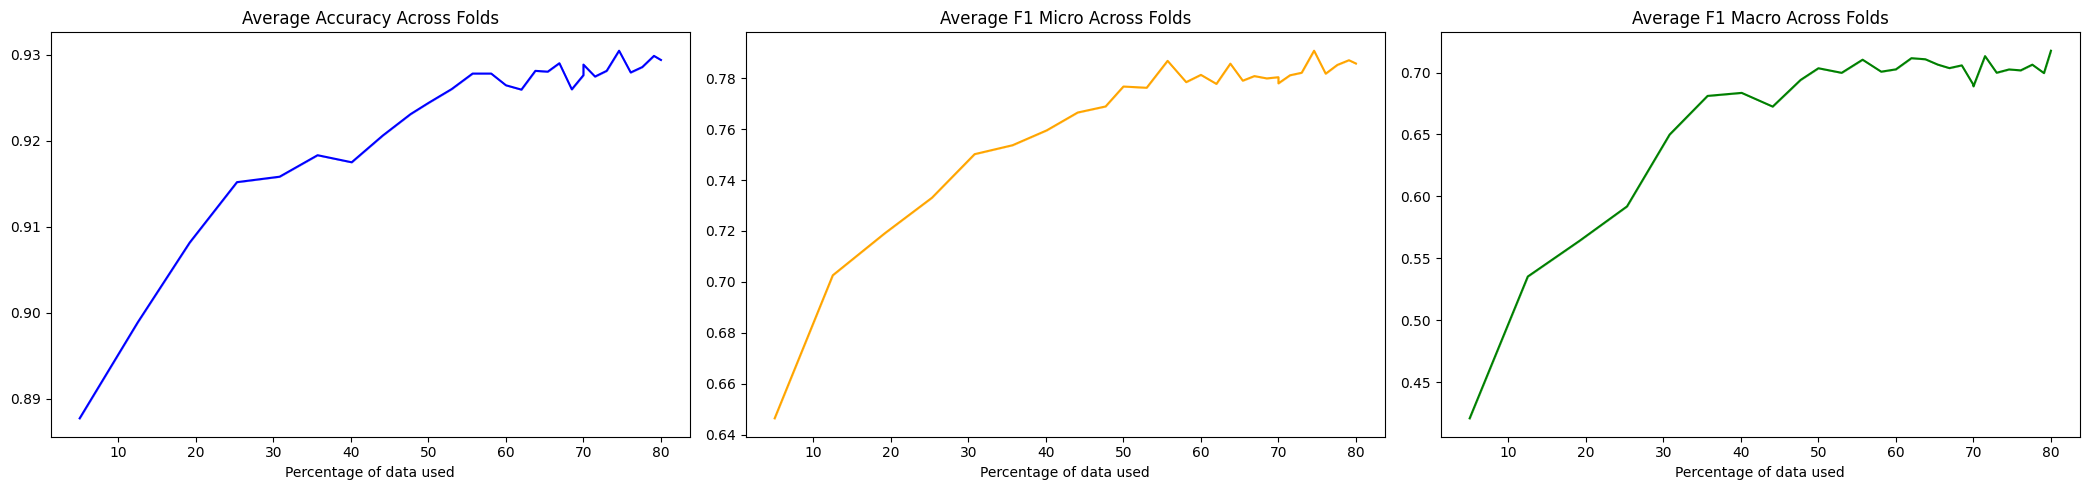

In [24]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(1):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

plt.tight_layout()
plt.show()

# for i in range(1, 2):
result = pd.DataFrame({
    'Data Used': all_fold_data_used[0],
    'Accuracy': all_fold_accuracies[0],
    'F1 Micro': all_fold_f1_micros[0],
    'F1 Macro': all_fold_f1_macros[0],
})

result.to_csv(f'{filename}-4-results.csv', index=False)